# Reproduction of: 
## *"ALBERTA’S FISCAL RESPONSES TO FLUCTUATIONS IN NON-RENEWABLE-RESOURCE REVENUE"*
## in python

This notebook attempts to replicate the empirical results, tables, and figures produced in the paper by Ergete Ferede, published by the University of Calgary school of public policy in Volume 11:24, September 2018.
The original paper is here: [https://www.policyschool.ca/wp-content/uploads/2018/09/NRR-Ferede.pdf](https://www.policyschool.ca/wp-content/uploads/2018/09/NRR-Ferede.pdf)

## Setup and data acquisition

This section of the code loads required modules, downloads the required data sets, and reads them into DataFrames

In [1]:
from pathlib import Path
import datetime as dt
import requests
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import stats_can
import altair as alt
import seaborn as sns
from arch.unitroot import DFGLS, ADF, PhillipsPerron
%matplotlib inline

### Historical budget data

Functions in this section are concerned with acquiring historical Alberta budget data and reading it into a DataFrame

In [2]:
def download_budget_data():
    """Download the excel file for the analysis from the policy school page
    
    Note the readme sheet on the first file. Credit to Kneebone and Wilkins for
    assembling it, and policy school for hosting it
    
    Returns
    -------
    fname: pathlib.Path
        A path object with the location and name of the data
    """
    print('Downloading data set')
#     url = 'https://www.policyschool.ca/wp-content/uploads/2019/01/Provincial-Government-Budget-Data-January-2019FINAL-USE.xlsx'
    url = 'https://www.policyschool.ca/wp-content/uploads/2019/03/Provincial-Government-Budget-Data-March-2019.xlsx'
    response = requests.get(
        url,
        stream=True,
        headers={'user-agent': None}
    )
    fname = Path('.').joinpath('data').joinpath('budgets.xlsx')
    with open (fname, 'wb') as outfile:
        for chunk in response.iter_content(chunk_size=512):
            if chunk: # filter out keep-alive new chunks
                outfile.write(chunk)
    return fname

def get_budget_file(force_update=False):
    """Return the data set, download if necessary"""
    fname = Path('.').joinpath('data').joinpath('budgets.xlsx')
    if not fname.exists() or force_update:
        download_budget_data()
    return fname


def get_date_index(df):
    """Helper function to turn budget year strings into datetimes"""
    date_index = pd.to_datetime(
        df
        .assign(year=lambda df: df['budget_yr'].str[0:4].astype(int))
        .assign(month=1)
        .assign(day=1)
        [['year', 'month', 'day']]
    )
    return date_index


def read_ab_budget():
    """Read Alberta budget data 
    
    Downloads the data if necessary, reads it in and gives
    the variables easier to work with names
    
    Returns
    -------
    df: pandas.DataFrame
        Alberta's revenue and expenditure tables
    """
    fname = get_budget_file()
    df = (
        pd.read_excel(
            fname,
            sheet_name='Alberta',
            header=3,
            index_col=1,
            skipfooter=21
        )
        # Because of the merged cells we get an empty first row
        .loc[lambda x: x.index.notnull()]
        # Not sure where the empty first column comes from but drop it
        .drop(columns='Unnamed: 0')
        .reset_index()
        .rename(columns={
            'index': 'budget_yr',
            'Personal Income Tax': 'personal_income_tax',
            'Corporation Income Tax': 'corporate_income_tax',
            'Retail Sales Tax': 'retail_sales_tax',
            'Federal Cash Transfers': 'federal_cash_transfers',
            'Natural Resource Revenue': 'natural_resource_revenue',
            'Other Own-Source Revenue': 'other_own_source_revenue',
            'Total Revenue': 'total_revenue',
            'Health': 'health_exp',
            'Social Services': 'social_services_exp',
            'Education': 'education_exp',
            'Other Program Expenditures': 'other_program_exp',
            'Total Program Expenditures': 'total_prog_exp',
            'Debt Service': 'debt_service',
            'Total  Expenditures': 'total_exp',
            'Unnamed: 16': 'annual_deficit'
        })
        .assign(budget_dt=lambda df: get_date_index(df))
        .set_index('budget_dt')
    )  
    return df

def read_heritage():
    """Heritage Trust fund deposits are separate"""
    fname = get_budget_file()
    df = (
        pd.read_excel(
            fname,
            sheet_name='Alberta',
            header=None,
            usecols='D:G',
            names=['budget_yr', 'resource_allocation', 'deposits', 'advance_edu'],
            skiprows=71,
            skipfooter=1
        )
        .loc[lambda df: ~df['budget_yr'].isna()]
        .set_index('budget_yr')
        .fillna(0)
        .assign(total_heritage=lambda df: df.sum(axis='columns'))
        # Add a dummy variable to indicate heritage fund deposit years
        .assign(heritage_dummy=1)
        .reset_index()
        .assign(budget_dt=lambda df: get_date_index(df))
        .drop(columns='budget_yr')
        .set_index('budget_dt')
    )
    return df


def clean_budget():
    """Combine base budget with heritage deposits"""
    budg = read_ab_budget()
    heritage= read_heritage()
    budg_clean = (
        budg
        .assign(other_revenue=lambda df: df[['retail_sales_tax', 'federal_cash_transfers', 'other_own_source_revenue']].sum(axis='columns'))
        .reindex(columns=['personal_income_tax', 'corporate_income_tax', 'natural_resource_revenue', 'other_revenue', 'total_prog_exp', 'debt_service'])
        .merge(heritage[['total_heritage', 'heritage_dummy']], how='left', left_index=True, right_index=True)
        .fillna(0)
        .assign(natural_resource_revenue_before_heritage=lambda df: df['natural_resource_revenue'])
        .assign(natural_resource_revenue=lambda df: df['natural_resource_revenue'] - df['total_heritage'])
        .assign(total_revenue=lambda df: df[['personal_income_tax', 'corporate_income_tax', 'natural_resource_revenue', 'other_revenue']].sum(axis='columns'))
        .assign(total_expenditure=lambda df: df[['total_prog_exp', 'debt_service']].sum(axis='columns'))
        .assign(deficit=lambda df: df['total_expenditure'] - df['total_revenue'])
        .astype('float64')
    )
    return budg_clean

### Real Per Capita budget

Functions in this section transform the nominal total budget numbers acquired in the previous section into real per-capita figures

In [3]:
def monthly_to_budget_annual(df, index_name):
    """Take a monthly indexed dataframe and annualize it by budget period
    
    Parameters
    ----------
    df: pandas.DataFrame
        DataFrame to be piped into this function
    index_name: The name of the date index
    """
    df = (
        df
        .copy()
        .rolling(4, closed='left')
        .mean()
        .reset_index()
        .assign(budget_dt=lambda df: df[index_name] - pd.DateOffset(years=1))
        .loc[lambda x: x['budget_dt'].dt.year >= 1965]
        .loc[lambda x: x['budget_dt'].dt.month == 1]
        .drop(columns=index_name)
        .set_index('budget_dt')
        .copy()
    )
    return df
    

def per_capita_data():
    """Read in population data to calculate per capita estimates
    
    Rolling mean indexed on January year N+1 is the March to March
    average population for fiscal year N
    Applying a date offset of -1 year and taking only
    January data of these rolling means gives us a population average
    on the same basis as the fiscal tables
    """
    table = '17-10-0009-01'
    df = (
        stats_can.table_to_df(table, path='data')
        .loc[lambda x: x['GEO'] == 'Alberta']
        .loc[lambda x: x['REF_DATE'] >= '1965']
        .set_index('REF_DATE')
        [['VALUE']]
        .rename(columns={'VALUE':'population'})
        .pipe(monthly_to_budget_annual, 'REF_DATE')
    )
    return df


def inflation_data():
    """Read in inflation data to calculate real dollar estimates
    
    Rolling mean indexed on January year N+1 is the March to March
    average population for fiscal year N
    Applying a date offset of -1 year and taking only
    January data of these rolling means gives us an average on the
    same basis as the budget dates. The whole series is then scaled so
    2017 budget year is = 1
    """
    vecs = ('v41692327', 'v41690973')
    df = (
        stats_can.vectors_to_df_local(vecs, path='data', start_date=dt.date(1965, 1, 1))
        .rename(columns={'v41692327': 'ab_inflation', 'v41690973': 'ca_inflation'})
    )
    mask = df['ab_inflation'].isna()
    df.loc[mask, 'ab_inflation'] = df.loc[mask, 'ca_inflation']
    df = (
        df
        .drop(columns='ca_inflation')
        .pipe(monthly_to_budget_annual, 'REF_DATE')
    )
    # Rescale to 2017 = 100 (this is fiscal year 2017, original may have done calendar year)
    inf_2017 = float(df.loc['2017', 'ab_inflation'])
    df = df / inf_2017
    return df


def budget_real_per_capita():
    """Take total current dollar budget results
    and covert them to per capital constant 2017 dollars
    """
    clean_budget_df = clean_budget()
    scale_cols = clean_budget_df.columns.drop('heritage_dummy').tolist()
    per_capita = per_capita_data()
    inflation = inflation_data()
    dfpc = (
        clean_budget_df
        .assign(pop=per_capita)
        .assign(cpi=inflation)
    )
    dfpc[scale_cols] = (
        dfpc[scale_cols]
        .mul(1_000_000)
        .div(dfpc['pop'], axis='index')
        .div(dfpc['cpi'], axis='index')
    )
    return dfpc

### Exogenous factors

The paper lists the Alberta employment rate, the Alberta unemployment rate, and the CAD/USD exchange rate as exogenous factors included in the model. Functions in this section acquire that data.

In [4]:
def download_historical_cad_usd():
    """FRED live data only goes back to 1971, I need a longer series
    This was what I could find. It's annual only, so I can't do it on a budget
    year basis, but hopefully it will be close enough
    """
    url = 'https://fxtop.com/en/historical-exchange-rates.php?YA=1&C1=USD&C2=CAD&A=1&YYYY1=1953&MM1=01&DD1=01&YYYY2=2019&MM2=04&DD2=01&LANG=en'
    df = pd.read_html(url)[29]
    headers = df.iloc[0]
    new_df  = (
        pd.DataFrame(df.values[1:], columns=headers)
        .rename(columns={'Year': 'year', 'Average USD/CAD': 'EXCAUS'})
        .assign(month=1)
        .assign(day=1)
        .assign(budget_dt=lambda df: pd.to_datetime(df[['year', 'month', 'day']]))
        .set_index('budget_dt')
        .reindex(columns=['EXCAUS'])
    )
    new_df.to_csv('./data/early_cad_usd.csv')
    return new_df


def read_historical_cad_usd(force_update=False):
    """Return the data set, download if necessary"""
    fname = Path('.').joinpath('data').joinpath('early_cad_usd.csv')
    if not fname.exists() or force_update:
        return download_historical_cad_usd()
    else:
        return pd.read_csv(fname).set_index('budget_dt')


def download_cad_usd():
    """Download monthly exchange data from FRED"""
    df = pdr.get_data_fred('EXCAUS', start=dt.date(1970, 1, 1))
    df.to_csv('./data/cad_usd.csv')
    return df


def read_cad_usd(force_update=False):
    """Return the data set, download if necessary"""
    fname = Path('.').joinpath('data').joinpath('cad_usd.csv')
    if not fname.exists() or force_update:
        return download_cad_usd()
    else:
        return pd.read_csv(fname, parse_dates=['DATE']).set_index('DATE')

    
def annual_cad_usd():
    """Full series of CAD/USD
    
    Get FRED data and turn the monthly values into annualized on a budget
    basis for as much as possible. Fill in the remainder with calendar annual
    data from fxtop
    """
    annual_date_range = pd.date_range('1964-01-01', '2018-01-01', freq='AS', name='budget_dt')
    old_df = read_historical_cad_usd()
    df = (
        read_cad_usd()
        .pipe(monthly_to_budget_annual, 'DATE')
        .reindex(annual_date_range)
        .fillna(old_df)
    )
    return df

def stats_can_exog():
    """Bring in exogenous StatsCan data"""
    ur_vec = "v2064516"
    er_vec = "v2064518"
    annual_date_range = pd.date_range('1964-01-01', '2018-01-01', freq='AS', name='budget_dt')
    old_df = (
        stats_can.table_to_df('36-10-0345-01', path='data')
        .loc[lambda x: x['GEO'] == 'Alberta']
        .loc[lambda x: x['Economic indicators'].isin(['Population', 'Total employment', 'Unemployment rate'])]
        .pivot_table(index='REF_DATE', columns='Economic indicators', values='VALUE')
        .rename(columns={'Unemployment rate': 'unemployment_rate'})
        .assign(employment_rate=lambda x: (x['Total employment'] / x['Population']) * 100)
        .reindex(columns=['unemployment_rate', 'employment_rate'])
        .rename_axis('budget_dt', axis='index')
        .rename_axis(None, axis='columns')
    )

    df = (
        stats_can.vectors_to_df_local([ur_vec, er_vec], path='data', start_date=dt.date(1964, 1, 1))
        .rename(columns={ur_vec: 'unemployment_rate', er_vec: 'employment_rate'})
        .pipe(monthly_to_budget_annual, 'REF_DATE')
        .reindex(annual_date_range)
        .fillna(old_df)
        .fillna(method='bfill') # Still can't quite get back far enough
    )
    return df

def exogenous_variables():
    """Bring in exogenous parameters
    
    From the paper:
    We also include other exogenous variables that are likely to affect
    the province’s budget. It is known that the various components of the
    provincial budget can be influenced by the business cycle. Thus, following
    Buettner and Wildsain (2006), we account for the potential effects of the
    business cycle by including one-period lagged changes in the provincial
    employment and unemployment rates. Another important exogenous factor
    that is often cited in provincial budget documents as being important in
    influencing the provincial government’s oil royalty revenue is the Canadian-U.S.
    dollar exchange rate. For this reason, we control for this factor by
    including one period lagged changes in the Canadian-U.S. dollar exchange rate
    """
    cadusd = annual_cad_usd()
    ur_er = stats_can_exog()
    df = pd.concat([cadusd, ur_er], axis='columns')
    return df

## Exploratory Figures

### Figure 1
Page 5 of the report charts Non-renewable Resource Revenue, Total Expenditure, and Total Revenue. All are in per-capita 2017 dollars.
Reproducing this chart will be a good starting check that my data extraction and transformation matches the original author's strategy

In [5]:
df = budget_real_per_capita()

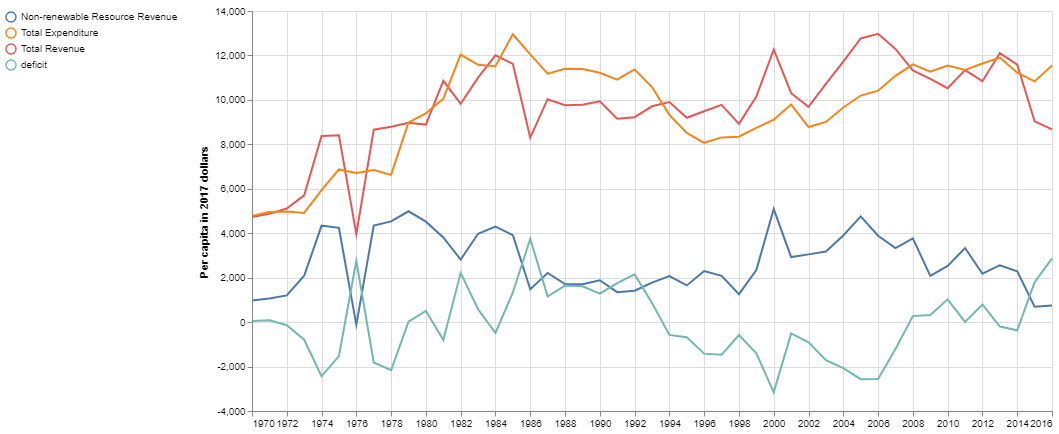

In [6]:
chart_df = (
    df
    .loc['1970':'2016', ['natural_resource_revenue', 'total_revenue', 'total_expenditure', 'deficit']]
    .rename(columns={
        'natural_resource_revenue': 'Non-renewable Resource Revenue',
        'total_revenue': 'Total Revenue',
        'total_expenditure': 'Total Expenditure'
    })
    .reset_index()
    .melt(id_vars='budget_dt')
)
chart = (
    alt.Chart(chart_df)
    .mark_line()
    .encode(
        x=alt.X('budget_dt:T', axis=alt.Axis(title=None)),
        y=alt.Y('value:Q', axis=alt.Axis(title='Per capita in 2017 dollars')),
        color=alt.Color('variable:N', legend=alt.Legend(title=None, orient='left'))
    )
    .properties(width=800, height=400)
)
chart

This graph looks very similar to the chart in the paper, with a notable exception of the 1976/1977 budget year. My chart shows Non-renewable Resource Revenue as slightly negative, whereas the original chart has it largely in line with 1975/1976 and 1977/1978. NRR is negative in my chart because I have netted out contributions to the Alberta Heritage Savings Trust Fund (AHSTF). To the best of my understanding, the original paper does the same, and the consistent values between the two in all other years supports that. Quoting the original paper:

>The part of resource revenue that is saved in the AHSTF is not expected to influence the provincial government’s spending and revenue-raising choices. For this reason, in our analysis, we exclude the part of the resource revenue that is saved in the AHSTF from the non-renewable-resource revenue data. 

For comparison, here is the same chart, but without netting AHSTF contributions:

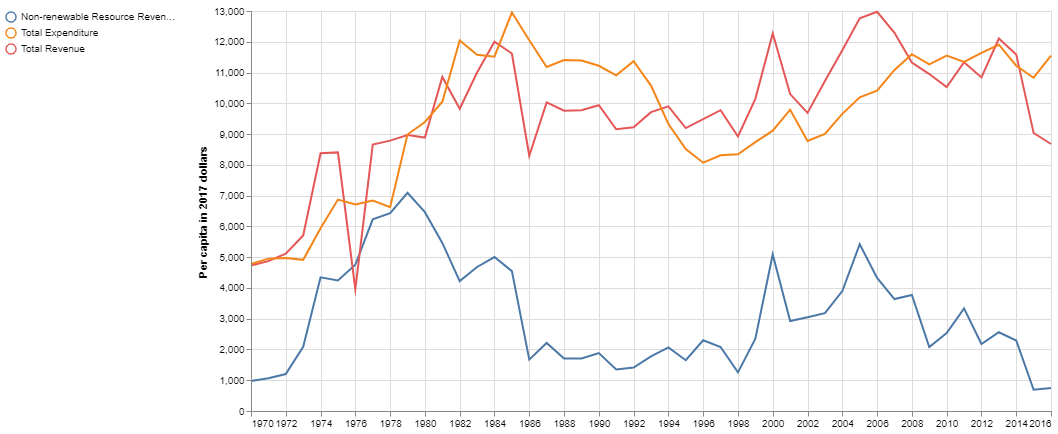

In [7]:
chart_df = (
    df
    .loc['1970':'2016', ['natural_resource_revenue_before_heritage', 'total_revenue', 'total_expenditure']]
    .rename(columns={
        'natural_resource_revenue_before_heritage': 'Non-renewable Resource Revenue (before AHSTF contributions)',
        'total_revenue': 'Total Revenue',
        'total_expenditure': 'Total Expenditure'
    })
    .reset_index()
    .melt(id_vars='budget_dt')
)
chart = (
    alt.Chart(chart_df)
    .mark_line()
    .encode(
        x=alt.X('budget_dt:T', axis=alt.Axis(title=None)),
        y=alt.Y('value:Q', axis=alt.Axis(title='Per capita in 2017 dollars')),
        color=alt.Color('variable:N', legend=alt.Legend(title=None, orient='left'))
    )
    .properties(width=800, height=400)
)
chart

1976/1977 more closely matches the original chart in the paper, but the remaining years in the period of mid 70s to mid 80s when there were significant contributions clearly do not match. Going forward all analysis in this reproduction will treat NRR as net of AHSTF contributions.

### Figure 2

Page 6 of the paper produces a scatter plot of Real per capita non-renewable resource revenue on the X axis vs. Real per capita budget balance on the Y, along with a linear trend fit.

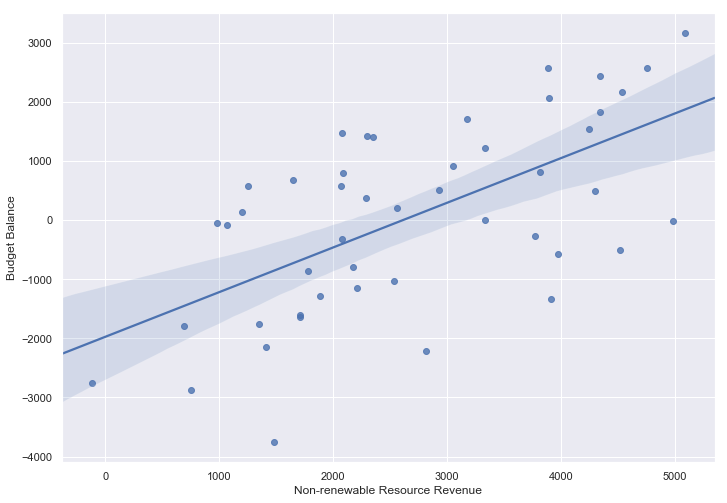

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
chart_df = (
    df
    .loc['1970':'2016', ['natural_resource_revenue', 'deficit']]
    .rename(columns={
        'natural_resource_revenue': 'Non-renewable Resource Revenue',
        'deficit': 'Deficit'
    })
    .assign(balance=lambda df: df['Deficit'] * -1)
    .rename(columns={'balance': 'Budget Balance'})
    .copy()
)
sns.regplot(x='Non-renewable Resource Revenue', y='Budget Balance', data=chart_df);

With the exception of the outlier previously noted in the time series view of the plot, this representation also looks very similar to what was in the original paper.

## Model Specification and estimation

This section combines the previously specified data extraction with transformations necessary to produce, summary statistics, statistical tests, and the VAR model itself.

In [9]:
def model_df_levels():
    """Combine real per capita budget data to get model data in levels
    
    lag exogenous variables (unemployment and employment rates, CAD/USD exchange)
    """
    budg = budget_real_per_capita()
    exog = exogenous_variables()
    df = (
        pd.concat([budg, exog], axis='columns')
        .rename(columns={'total_prog_exp': 'program_expenditure', 'EXCAUS': 'cad_usd'})
        .assign(ur_lag=lambda df: df['unemployment_rate'].shift(periods=1))
        .assign(er_lag=lambda df: df['employment_rate'].shift(periods=1))
        .assign(cad_usd_lag=lambda df: df['cad_usd'].shift(periods=1))
        .reindex(columns=[
            'program_expenditure', 'debt_service', 'corporate_income_tax',
            'personal_income_tax', 'other_revenue', 'natural_resource_revenue',
            'deficit', 'heritage_dummy', 'ur_lag', 'er_lag', 'cad_usd_lag'
        ])
    )
    return df

In [10]:
mdfl = model_df_levels()

### Sumary statistics for key variables, 1970-71, 2016-17 in levels

Reproduce the top half of table 1 from the paper

In [11]:
number = "{:0<4,.1f}"
percent = '{:.1%}'
count = "{:0.0f}"

df = (
    mdfl
    .loc['1970':'2016']
    .copy()
    .drop(columns=['heritage_dummy'])
    .reindex(columns=[
        'natural_resource_revenue', 'corporate_income_tax', 'personal_income_tax',
        'other_revenue', 'debt_service', 'program_expenditure', 'deficit', 'ur_lag',
        'er_lag', 'cad_usd_lag'
    ])
    .describe()
    .T
    .style.format({
        'count': count,
        'mean': number,
        'std': number,
        'min': number,
        '25%': number,
        '50%': number,
        '75%': number,
        'max': number
    })
)
df

,count,mean,std,min,25%,50%,75%,max
natural_resource_revenue,47,"2,692.0","1,315.6",-121.9,"1,707.8","2,346.9","3,890.7","5,087.7"
corporate_income_tax,47,783.6,351.4,245.4,533.6,718.7,"1,009.9","1,549.3"
personal_income_tax,47,"1,842.5",615.5,750.4,"1,397.7","1,882.8","2,355.8","2,826.1"
other_revenue,47,"4,345.7","1,099.9","2,246.8","3,584.9","4,679.0","5,132.5","5,805.1"
debt_service,47,320.1,332.6,29.6,79.6,157.7,482.2,"1,069.7"
program_expenditure,47,"9,285.4","2,182.3","4,738.7","7,597.3","9,947.2","11,097.7","12,782.8"
deficit,47,-58.3,"1,594.7","-3,158.1","-1,308.7",-137.9,"1,087.3","3,750.9"
ur_lag,47,6.10,2.20,3.30,4.50,5.30,7.70,11.1
er_lag,47,63.7,10.0,38.5,64.7,67.3,68.9,71.9
cad_usd_lag,47,1.20,0.20,1.00,1.10,1.20,1.30,1.60


All the figures that I can validate against (exogenous variables aren't reported in the paper) are reasonably close. The one noted difference is the previously described outlier in natural resource revenue which leads to my minimum for that variable being significantly lower than in the paper. My guess for the observed discrepancies are differences in calculating population or CPI. It will be interesting to see how sensitive the rest of the model is to these relatively small differences in transformation methodology.

### Sumary statistics for key variables, 1970-71, 2016-17, first difference

Reproduce the bottom half of table 1 from the paper

In [12]:
def model_df_first_diff(mdfl):
    """Produce the first difference of the level model df"""
    df = (
        mdfl
        .diff()
        .loc['1970':'2016']
        .copy()
        .assign(heritage_dummy=mdfl['heritage_dummy']) # don't want to lag diff this
        .assign(constant=1)
        .assign(zero=0)
        .assign(nrrd=lambda df: df[['natural_resource_revenue', 'zero']].min(axis='columns'))
        .assign(nrri=lambda df: df[['natural_resource_revenue', 'zero']].max(axis='columns'))
        .reindex(columns=[
            'natural_resource_revenue', 'nrri', 'nrrd', 'corporate_income_tax', 'personal_income_tax',
            'other_revenue', 'debt_service', 'program_expenditure', 'deficit', 'ur_lag',
            'er_lag', 'cad_usd_lag', 'heritage_dummy', 'constant'
        ])
    )
    return df

In [13]:
df = (
    model_df_first_diff(mdfl)
    .drop(columns=['heritage_dummy', 'constant'])
    .describe()
    .T
    .style.format({
        'count': count,
        'mean': number,
        'std': number,
        'min': number,
        '25%': number,
        '50%': number,
        '75%': number,
        'max': number
    })
)
df

,count,mean,std,min,25%,50%,75%,max
natural_resource_revenue,47,-7.9,"1,325.5","-4,364.7",-519.2,89.7,454.4,"4,466.5"
nrri,47,426.3,826.2,0.00,0.00,89.7,454.4,"4,466.5"
nrrd,47,-434.3,834.3,"-4,364.7",-519.2,0.00,0.00,0.00
corporate_income_tax,47,13.4,197.7,-458.3,-101.1,26.4,139.3,422.7
personal_income_tax,47,42.9,221.5,-679.0,-35.7,42.8,142.8,923.3
other_revenue,47,42.6,570.9,"-1,219.9",-261.3,-59.1,144.9,"2,331.0"
debt_service,47,4.50,85.0,-249.0,-20.1,1.30,35.8,219.9
program_expenditure,47,148.8,733.8,"-1,275.8",-248.4,146.9,541.4,"2,375.3"
deficit,47,62.3,"1,543.8","-4,573.9",-814.7,-46.1,836.1,"4,289.7"
ur_lag,47,0.10,1.30,-2.3,-0.6,-0.1,0.60,5.40


The outlier in natural resource revenue really skews the first difference max and min, and increases the standard deviation. Again, it will be interesting to see how this impacts the parameter estimates.

### Unit-Root Tests

Table A1 in the paper shows the results of unit root tests for both the level and first differenced variables in the model. This section will reproduce those tables

In [14]:
level_stationarity_df = (
    mdfl
    .loc['1970':'2016']
    .copy()
    .drop(columns=['heritage_dummy'])
    .reindex(columns=[
        'natural_resource_revenue', 'corporate_income_tax', 'personal_income_tax',
        'other_revenue', 'debt_service', 'program_expenditure', 'deficit', 'ur_lag',
        'er_lag', 'cad_usd_lag'
    ])
)

In [15]:
first_diff_stationarity_df = (
    model_df_first_diff(mdfl)
    .drop(columns=['heritage_dummy', 'constant'])
)

In [16]:
def stationarity_tests(df):
    tests_dict = {'ADF': ADF, 'Phillips-Perron': PhillipsPerron, 'DF-GLS': DFGLS}
    cols = df.columns
    tests_df = pd.DataFrame()
    for test_label, test in tests_dict.items():
        for col in cols:
            if test_label != 'Phillips-Perron':
                col_test = test(df[col], method='BIC')
            else:
                col_test = test(df[col])
            test_val = col_test.stat
            test_p = col_test.pvalue
            test_summary = f'val: {test_val:0.3f}, p: {test_p:.1%}'
            tests_df.loc[col, test_label] = test_summary
    return tests_df

In [17]:
stationarity_tests(level_stationarity_df)

,ADF,Phillips-Perron,DF-GLS
natural_resource_revenue,"val: -3.943, p: 0.2%","val: -4.052, p: 0.1%","val: -3.127, p: 0.2%"
corporate_income_tax,"val: -2.282, p: 17.8%","val: -2.212, p: 20.2%","val: -1.643, p: 9.8%"
personal_income_tax,"val: -1.563, p: 50.2%","val: -1.343, p: 60.9%","val: -0.633, p: 45.8%"
other_revenue,"val: -2.123, p: 23.5%","val: -1.989, p: 29.1%","val: -1.557, p: 11.6%"
debt_service,"val: -1.552, p: 50.8%","val: -1.696, p: 43.3%","val: -1.380, p: 16.1%"
program_expenditure,"val: -2.954, p: 3.9%","val: -2.049, p: 26.6%","val: -0.659, p: 44.5%"
deficit,"val: -3.466, p: 0.9%","val: -3.874, p: 0.2%","val: -3.494, p: 0.1%"
ur_lag,"val: -2.242, p: 19.1%","val: -2.242, p: 19.1%","val: -1.821, p: 6.8%"
er_lag,"val: -2.502, p: 11.5%","val: -2.949, p: 4.0%","val: -0.836, p: 36.3%"
cad_usd_lag,"val: -1.720, p: 42.1%","val: -1.792, p: 38.5%","val: -1.543, p: 12.0%"


In [18]:
stationarity_tests(first_diff_stationarity_df)

,ADF,Phillips-Perron,DF-GLS
natural_resource_revenue,"val: -7.415, p: 0.0%","val: -10.282, p: 0.0%","val: -7.452, p: 0.0%"
nrri,"val: -6.868, p: 0.0%","val: -6.885, p: 0.0%","val: -6.513, p: 0.0%"
nrrd,"val: -7.879, p: 0.0%","val: -9.313, p: 0.0%","val: -7.653, p: 0.0%"
corporate_income_tax,"val: -7.131, p: 0.0%","val: -8.366, p: 0.0%","val: -7.027, p: 0.0%"
personal_income_tax,"val: -5.463, p: 0.0%","val: -8.895, p: 0.0%","val: -6.689, p: 0.0%"
other_revenue,"val: -7.929, p: 0.0%","val: -8.147, p: 0.0%","val: -7.634, p: 0.0%"
debt_service,"val: -3.880, p: 0.2%","val: -4.216, p: 0.1%","val: -3.892, p: 0.0%"
program_expenditure,"val: -2.532, p: 10.8%","val: -6.217, p: 0.0%","val: -2.398, p: 1.7%"
deficit,"val: -2.469, p: 12.3%","val: -10.010, p: 0.0%","val: -2.489, p: 1.3%"
ur_lag,"val: -5.814, p: 0.0%","val: -5.713, p: 0.0%","val: -5.810, p: 0.0%"


Documentation on the test tools I used can be found [here](https://arch.readthedocs.io/en/latest/unitroot/tests.html)

There are some interesting differences. Most notable is that on the levels of the deficit series I reject the null hypothesis of a unit root using all three tests at a significance level < 1%. The paper specifically notes that if the deficit is stationary in levels then a Vector Error Correction model can be applied. As the original author's fails to reject the null he implements a Vector AutoRegression model on the first differenced data. In levels the only other series that I find to be stationary is natural resource revenue. ADF on program expenditure would also reject the null at 5% significance, but would fail to reject it using the other two tests.

Looking at the first differenced series, since that's what the paper ultimately ends up using, I also reject the null hypothesis of a unit root for all variables using all tests at a 1% significant *except* program expenditure and deficit using Augmented Dickey Fuller. Those last two tests differ from what's reported in the paper. 

The paper notes that it uses the Schwarz Information Criterion (SIC) for determining optimal lags in the DF-GLS test. It doesn't specify what it's using in the other two tests. For ADF and DF-GLS I used the Schwarz/Bayesian IC (BIC), [which is just another name for SIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion). Phillips-Perron only uses 1 lag and then Newey-West for a long run variance estimator. I also ran these tests using Akaike IC (AIC) for optimal lags for ADF and DF-GLS, with similar results. I'm not sure what explains the discrepancies in my results with what's reported in the paper

### The Model

Take the first differenced dataframe and produce a VAR model using it

In [19]:
from statsmodels.tsa.api import VAR

In [20]:
vec_df = (
    model_df_first_diff(mdfl)
    .drop(columns='natural_resource_revenue')
)
vec_df.columns
endog_df = vec_df[[
    'nrri', 'nrrd', 'program_expenditure', 'debt_service', 'corporate_income_tax',
     'personal_income_tax', 'other_revenue'
]]
exog_df = vec_df[['ur_lag', 'er_lag', 'cad_usd_lag', 'heritage_dummy']]
model = VAR(endog=endog_df, exog=exog_df, freq='AS')

C:\ProgramData\Anaconda3\envs\fpa_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [21]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Apr, 2019
Time:                     14:02:35
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    88.4267
Nobs:                     45.0000    HQIC:                   85.0776
Log likelihood:          -2183.42    FPE:                1.80103e+36
AIC:                      83.0870    Det(Omega_mle):     1.53020e+35
--------------------------------------------------------------------
Results for equation nrri
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                         337.727223       155.056172            2.178           0.029
exog0                         128.009878       122.474698            1.045           0.296
exog1                